In [1]:
import numpy as np
import pandas as pd

# Data Import

In [2]:
abnb = pd.read_csv('AB_NYC_2019.csv')
abnbv3 = pd.read_csv('ABNB_NY_V3.csv')
abnb = pd.concat((abnb,abnbv3['dist_subway']),axis=1)
abnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 17 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

# Drop Shared Rooms

In [3]:
print(abnb.shape)
idx = abnb[abnb['room_type'] == 'Shared room'].index
abnb.drop(idx , inplace=True)
print(abnb.shape)

(48895, 17)
(47735, 17)


Dropping shared rooms from the data because they are a minority class, we want to focus on the major classes.

# Make Dummies for Neighborhood Group and Room Type

In [4]:
ngdummy = pd.get_dummies(abnb.neighbourhood_group,prefix='neigh_group')
abnb = pd.concat((abnb,ngdummy),axis=1)

roomdummy = pd.get_dummies(abnb.room_type,prefix='room_type')
abnb = pd.concat((abnb,roomdummy),axis=1)
abnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47735 entries, 0 to 48894
Data columns (total 24 columns):
id                                47735 non-null int64
name                              47720 non-null object
host_id                           47735 non-null int64
host_name                         47714 non-null object
neighbourhood_group               47735 non-null object
neighbourhood                     47735 non-null object
latitude                          47735 non-null float64
longitude                         47735 non-null float64
room_type                         47735 non-null object
price                             47735 non-null int64
minimum_nights                    47735 non-null int64
number_of_reviews                 47735 non-null int64
last_review                       37997 non-null object
reviews_per_month                 37997 non-null float64
calculated_host_listings_count    47735 non-null int64
availability_365                  47735 non-null int64

# Checking room type counts

In [5]:
abnb.room_type.value_counts()

Entire home/apt    25409
Private room       22326
Name: room_type, dtype: int64

# Train Test Split

In [6]:

from sklearn.model_selection import train_test_split

X = abnb[[  'latitude',
            'longitude',
            'price',
            'dist_subway',
            'minimum_nights',
            'number_of_reviews',
            'calculated_host_listings_count',
            'availability_365',
            'neigh_group_Bronx',
            'neigh_group_Brooklyn',
            'neigh_group_Queens',
            'neigh_group_Staten Island']]

y = abnb[['room_type']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314159)
y_train = y_train.values.ravel()
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (38188, 12)
X_test shape:  (9547, 12)
y_train shape:  (38188,)
y_test shape:  (9547, 1)


# Logistic Regression

In [7]:
# Code Adapted From: https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# Setup Logistic Regression Classifier
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' )

# Train the model 
lr_clf.fit(X_train,y_train)  

# Make predictions on test data
y_hat = lr_clf.predict(X_test) 

# Measure Accuracy
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print("accuracy", acc )
print("confusion matrix\n",conf)

accuracy 0.813239761181523
confusion matrix
 [[3890 1159]
 [ 624 3874]]


# Log Reg Weights

In [8]:
# Code Adapted From: https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = X_train.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

latitude has weight of 1.9976915433223634
longitude has weight of 1.07004282146264
price has weight of -0.018314722159266127
dist_subway has weight of -0.13276741386955246
minimum_nights has weight of -0.020625170231605084
number_of_reviews has weight of -0.002723287899270921
calculated_host_listings_count has weight of -0.007219554440270909
availability_365 has weight of 0.002111944123650888
neigh_group_Bronx has weight of -0.5904142120935824
neigh_group_Brooklyn has weight of -0.05295587013503004
neigh_group_Queens has weight of -0.12067401753934201
neigh_group_Staten Island has weight of -0.09841906910976699


# Scaling Variables for Feature Importance
Should I be scaling dummies?

In [9]:
# Code Adapted From: https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,X_train.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

D:\Users\William\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
D:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


accuracy: 0.8108306274222269
[[3869 1180]
 [ 626 3872]]
price has weight of -4.249849232718081
minimum_nights has weight of -0.3942661691583071
calculated_host_listings_count has weight of -0.2397233951335336
number_of_reviews has weight of -0.11823438455511193
neigh_group_Bronx has weight of -0.08338786872445268
dist_subway has weight of -0.030079532834932445
neigh_group_Staten Island has weight of -0.005667503921976151
neigh_group_Queens has weight of -0.005507169455763638
longitude has weight of 0.03138149736635156
neigh_group_Brooklyn has weight of 0.036021302801874835
latitude has weight of 0.16457907793950807
availability_365 has weight of 0.2672604962715976


# Graph of feature importance

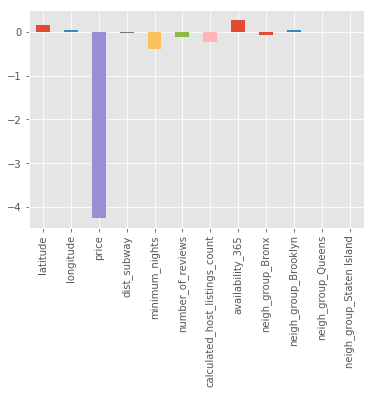

In [10]:
# Code Adapted From: https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=X_train.columns)
weights.plot(kind='bar')
plt.show()

# SVC Model

In [11]:
# Code Adapted From: https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8429873258615271
[[4175  874]
 [ 625 3873]]


# Support Vectors

In [12]:
# Code Adapted From: https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(17861, 12)
(17861,)
[8926 8935]
